# Measure Watson Assistant Performance 

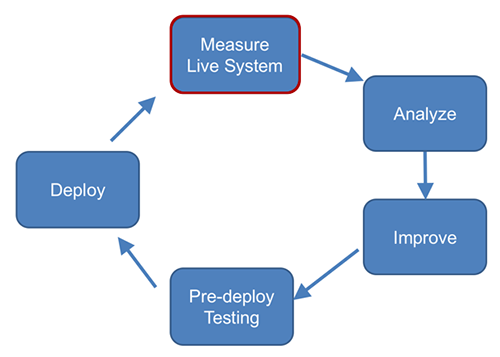

## Introduction

This notebook demonstrates how to setup automated metrics that help you measure, monitor, and understand the behavior of your Watson Assistant system. As described in _Watson Assistant Continuous Improvement Best Practices_, this is the first step of your continuous improvement process. The goal of this step is to understand where your assistant is doing well vs where it isn’t and to potentially focus your improvement effort to one of the problem areas identified. We define two measures to achieve this goal: **Coverage** and **Effectiveness**.

- **Coverage** is the portion of total user messages your assistant is attempting to respond to.

- **Effectiveness** refers to how well your assistant is handling the conversations it is attempting to respond to.

The pre-requisite for running this notebook is Watson Assistant (formerly Watson Conversation). This notebook assumes familiarity with Watson Assistant and concepts such as workspaces, intents and training examples. 

### Programming language and environment
Some familiarity with Python is recommended. This notebook runs on Python 3.5 with Default Python 3.5 XS environment.
***

## Table of contents

1. [Configuration and setup](#setup)<br>
    1.1 [Import and apply global CSS styles](#setup1)<br>
    1.2 [Install required Python libraries](#setup2)<br>
    1.3 [Import functions used in the notebook](#setup3)<br>
    1.4 [Add project token](#setup4)<br>
    1.5 [Add Watson Assistant configuration](#setup5)<br>
2. [Load and format data](#load)<br>
    2.1 [Connect to assistant](#load1)<br>
    2.2 [Fetch a workspace](#load2)<br>
    2.3 [Fetch workspace logs](#load3)<br>
    2.4 [Format the log data](#load4)<br>
3. [Define coverage and effectiveness metrics](#set_metrics)<br>
    3.1 [Customize coverage](#set_coverage)<br>
    3.2 [Customize effectiveness](#set_effectiveness)<br>
4. [Calculate overall coverage and effectiveness](#overall)<br>
    4.1 [Calculate overall metrics](#overall1)<br>
    4.2 [Display overall results](#overall2)<br>
5. [Analyze coverage](#msg_analysis)<br>
    5.1 [Display overall coverage](#msg_analysis1)<br>
    5.2 [Calculate coverage over time](#msg_analysis2)<br>
6. [Analyze effectiveness](#conv_analysis)<br>
    6.1 [Generate excel file and upload to our project](#conv_analysis1)<br>
    6.2 [Plot breakdown by effectiveness graph](#conv_analysis2)<br>
7. [Root cause analysis of non coverage](#root_cause)<br>
8. [Summary and next steps](#summary)<br>

<a id="setup"></a>
## 1. Configuration and Setup

In this section, we add data and workspace access credentials, import required libraries and functions.

### <a id="setup1"></a> 1.1 Import and apply global CSS styles

In [1]:
from IPython.display import HTML
!curl -O https://raw.githubusercontent.com/watson-developer-cloud/assistant-improve-recommendations-notebook/master/src/main/css/custom.css
HTML(open('custom.css', 'r').read())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   819  100   819    0     0    819      0  0:00:01 --:--:--  0:00:01 10500


### <a id="setup2"></a> 1.2 Install required Python libraries

In [2]:
# install watson-developer-cloud python SDK
# After running this cell once, comment out the following code. Packages only need to be installed once.
!pip install --upgrade "watson-developer-cloud>=1.0,<2.0";

# Import required libraries
import pandas as pd
from botocore.client import Config
import ibm_boto3
import datetime
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
from watson_developer_cloud import AssistantV1
from datetime import timedelta
import matplotlib.dates as mdates
import re
from project_lib import Project
import random
from IPython.display import display

pd.set_option('max_colwidth', -1)

Requirement already up-to-date: watson-developer-cloud<2.0,>=1.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: pyOpenSSL>=16.2.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud<2.0,>=1.0)
Requirement not upgraded as not directly required: python-dateutil>=2.5.3 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud<2.0,>=1.0)
Requirement not upgraded as not directly required: autobahn>=0.10.9 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud<2.0,>=1.0)
Requirement not upgraded as not directly required: requests<3.0,>=2.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud<2.0,>=1.0)
Requirement not upgraded as not directly required: Twisted>=13.2.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud<2.0,>=1.0)
Requirement not upgraded as

### <a id="setup3"></a> 1.3 Import functions used in the notebook

In [3]:
# Import function module files
!curl -O https://raw.githubusercontent.com/watson-developer-cloud/assistant-improve-recommendations-notebook/master/src/main/python/cos_op.py
!curl -O https://raw.githubusercontent.com/watson-developer-cloud/assistant-improve-recommendations-notebook/master/src/main/python/watson_assistant_func.py
!curl -O https://raw.githubusercontent.com/watson-developer-cloud/assistant-improve-recommendations-notebook/master/src/main/python/visualize_func.py
!curl -O https://raw.githubusercontent.com/watson-developer-cloud/assistant-improve-recommendations-notebook/master/src/main/python/computation_func.py
    
# Import the visualization related functions
from visualize_func import render_fig
from visualize_func import make_pie
from visualize_func import coverage_barh
from visualize_func import width_bar

# Import Cloud Object Storage related functions   
from cos_op import generate_link
from cos_op import generate_excel_measure

# Import Watson Assistant related functions
from watson_assistant_func import get_logs

# Import Dataframe computation related functions
from computation_func import intersection
from computation_func import get_effective_df
from computation_func import get_coverage_df
from computation_func import chk_is_valid_node
from computation_func import format_data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6914  100  6914    0     0   6914      0  0:00:01 --:--:--  0:00:01 88641
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3722  100  3722    0     0   3722      0  0:00:01 --:--:--  0:00:01 82711
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10171  100 10171    0     0  10171      0  0:00:01 --:--:--  0:00:01  220k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14485  100 14485    0     0  14485      0  0:00:01 --:--:--  0:00:01  505k


### <a id="setup4"></a> 1.4 Add project token

A project token is used to access data assets from notebooks. 

__How to set a project token__?

- Open another browser window, go to your Watson Studio Project page, and click on the Settings tab. Scroll down to Access tokens and click New token. Give the token a name and the Editor access role.

- Click into an empty line in the cell below. Use the menu item with the three vertical dots, and choose Insert project token. 

- Copy the inserted string and replace the line `project = Project(project_id='', project_access_token='')` with the equivalent string inserted by the menu item. 

Note that the Insert project token menu action sometimes creates a new cell in your notebook. You may need to find that cell and cut and paste the token information into the cell below.

For more information about project tokens, see [project token](https://dataplatform.cloud.ibm.com/docs/content/analyze-data/token.html).

In [4]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
project = Project(project_id='', project_access_token='')

### <a id="setup5"></a> 1.5 Add Watson Assistant configuration

Provide your Watson Assistant credentials and the workspace id that you want to fetch data from.   

- For more information about obtaining Watson Assistant credentials, see [Service credentials for Watson services](https://console.bluemix.net/docs/services/watson/getting-started-credentials.html#creating-credentials).
- API requests require a version parameter that takes a date in the format version=YYYY-MM-DD. For more information about version, see [Versioning](https://www.ibm.com/watson/developercloud/assistant/api/v1/curl.html?curl#versioning).


In [5]:
# Provide credentials to connect to assistant
creds = {'username':'',
         'password':'',
         'version':'2018-05-03'}

# Provide the workspace id you want to analyze
workspace_id = ''

## <a id="load"></a> 2. Load and format data 

### 2.1 <a id="load1"></a> Connect to Watson Assistant instance

In [6]:
# Connect to Watson Assistant
conversation = AssistantV1(username=creds['username'], 
                           password=creds['password'], 
                           version=creds['version'])

### <a id="load2"></a> 2.2 Fetch a workspace

Fetch the workspace for the workspace id given in `workspace_id` variable.

In [7]:
# Fetch the worksapce info. for the input workspace id
workspace = conversation.get_workspace(workspace_id = workspace_id, export=True)

# Store the workspace details in a dataframe
df_workspace = json_normalize(workspace)

# Get all intents present in current version of workspace
workspace_intents= [intent['intent'] for intent in df_workspace['intents'].values[0]] 

# Get all dialog nodes present in current version of workspace
workspace_nodes= pd.DataFrame(df_workspace['dialog_nodes'].values[0])

<a id="load3"></a>
### 2.3 Fetch workspace logs

Fetch the logs for the workspace id given in `workspace_id` variable. Any necessary filter can be specified in the `filter` variable.<br>
Note that if the logs were already fetched in a previous run, it will be read from the a cache file.

In [8]:
# Filter to be applied while fetching logs, e.g., removing empty input 'meta.summary.input_text_length_i>0', 'response_timestamp>=2018-09-18'
filter = 'meta.summary.input_text_length_i>0'

# Send this info into the get_logs function
project_creds={'project':project,'sdk_object':conversation, 'ws_id':workspace['workspace_id'], 'ws_name':workspace['name']}

# Fetch the logs for the workspace
df = get_logs(num_logs=10000, log_list=[], project_creds=project_creds, log_filter=filter)

Reading from file: Car Dashboard - Samplemeta.summary.input_text_length_i0_10000.json
Workspace logs loaded successfully with 7619 records


### <a id="load4"></a> 2.4 Format the log data

In [9]:
# Format the logs data from the workspace
df_formated = format_data(df)

<a id="set_metrics"></a>
## 3. Define effectiveness and coverage metrics
As described in Watson Assistant Continuous Improvement Best Practices, **Effectiveness** and **Coverage** are the two measures that provide a reliable understanding of your assistant’s overall performance. Both of the two measures are customizable based on your preferences. In this section, we provide a guideline for setting each of them.

### <a id="set_coverage"></a> 3.1 Customize coverage

Coverage measures your Watson Assistant system at the utterance level. You may include automated metrics that help identify utterences that your service is not answering. Example metrics include: 

- Confidence threshold
- Dialog information

For Confidence threshold, you can set a threshold to include utterances with confidence values below this threshold. For more information regarding Confidence, see [Absolute scoring](https://console.bluemix.net/docs/services/conversation/intents.html#absolute-scoring-and-mark-as-irrelevant).

For Dialog information, you can specify what the notebook should look for in your logs to determine that a message is not covered by your assistant.

- Use the node_ids list to include the identifiers of any dialog nodes you've used to model that a message is out of scope.  
- Similarly, use the node_names list to include any dialog nodes.
- Use node_conditions for dialog conditions that indicate a message is out of scope.
    
Note that these lists are treated as "OR" conditions - any occurrence of any of them will signify that a message is not covered. 

__Where to find node id, node name, and node condition__?

You can find the values of these variables from your workspace JSON file based on following mappings.

- node id: `dialog_node`
- node name: `title`
- node condition: `conditions`

You can also find node name, and node condition in your workspace dialog editor. For more information, see [Dialog Nodes].(https://console.bluemix.net/docs/services/conversation/dialog-overview.html#dialog-nodes)

Below we provide example code for identifying coverage based on confidence and dialog node. 

In [10]:
#Specify the confidence threhold you want to look for in the logs
confidence_threshold = .20

# Add coverage node ids, if any, to list
node_ids = ['node_1_1467910920863', 'node_1_1467919680248']

# Add coverage node names, if any, to list
node_names = []

# Add coverage node conditions, if any, to list
node_conditions = ['#out_of_scope || #off_topic', 'anything_else']

# Check if the dialog nodes are present in the current version of workspace
df_coverage_nodes = chk_is_valid_node(node_ids, node_names, node_conditions, workspace_nodes)
df_coverage_nodes

,Condition,Node ID,Node Name,Valid
0,true,node_1_1467910920863,NaN,True
1,true,node_1_1467919680248,NaN,True
2,#out_of_scope || #off_topic,node_1_1467743415843,NaN,True
3,anything_else,node_2_1487280430136,NaN,True


### <a id="set_effectiveness"></a> 3.2 Customize effectiveness

Effectiveness measures your Watson Assistant system at the conversation level. You may include automated metrics that help identify problematic conversations. Example metrics include:

- Escalations to live agent: conversations escalated to a human agent for quality reasons.
- Poor NPS: conversations that received a poor NPS (Net Promoter Score), or other explicit user feedback.
- Task not completed: conversations failed to complete the task the user was attempting.
- Implicit feedback: conversations containing implicit feedback that suggests failure, such as links provided not being clicked. 

Below we provide example code for identifying escalation based on intents and dialog information.

#### <a id="set_escalation_intent"></a> 3.2.1 Specify intents to identify escalations
If you have specific intents that point to escalation or any other effectiveness measure, specify those in `chk_effective_intents` lists below. <br>
**Note:** If you don't have specific intents to capture effectiveness, leave chk_effective_intents list empty.

In [11]:
# Add your escalation intents to the list
chk_effective_intents=['connect_to_agent']

# Store the intents in a dataframe
df_chk_effective_intents = pd.DataFrame(chk_effective_intents, columns = ['Intent'])

# Add a 'valid' flag to the dataframe
df_chk_effective_intents['Valid']= True

# Checking the validity of the specified intents. Look out for the `valid` column in the table displayed below.
for intent in chk_effective_intents:
    # Check if intent is present in workspace
    if intent not in workspace_intents:
        # If not present, mark it as 'not valid'
        df_chk_effective_intents.loc[df_chk_effective_intents['Intent']==intent,['Valid']] = False
        # Remove intent from the chk_effective_intents list 
        chk_effective_intents.remove(intent)
# Display intents and validity
df_chk_effective_intents

,Intent,Valid
0,connect_to_agent,True


#### <a id="set_escalation_dialog"></a> 3.2.2 Specify  dialog nodes to identify escalations
If you have specific dialog nodes that point to escalation or any other effectiveness measure, you can automated capture them based on three variables: node id, node name, and node condition.

- Use the node_ids list to include the identifiers of any dialog nodes you've used to model that a message indicates an escalation.  
- Similarly, use the node_names list to include dialog nodes.
- Use node_conditions for dialog conditions that indicate a message is out of scope.

Note that these lists are treated as "OR" conditions - any occurrence of any of them will signify that a message is not covered. 

__Where to find node id, node name, and node condition__?

You can find the values of these variables from your workspace JSON file based on following mappings.

- node id: `dialog_node`
- node name: `title`
- node condition: `conditions`

You can also find node name, and node condition in your workspace dialog editor. For more information, see [Dialog Nodes](https://console.bluemix.net/docs/services/conversation/dialog-overview.html#dialog-nodes).

**Note:** If your assistant does not incorporate escalations and you do not have any other automated conversation-level quality metrics to identify problematic conversations (e.g., poor NPS, task not completed), you can simply track coverage and average confidence over a recent sample of your entire production logs. Leave an empty list for node_ids, node_names and node_conditions.  

In [12]:
# Add effectiveness node ids, if any, to list
node_ids = []

# Add effectiveness node names, if any, to list
node_names = ['not_trained']

# Add effectiveness node conditions, if any, to list
node_conditions = ['#connect_to_agent', '#answer_not_helpful']

# If your assistant does not incorporate escalations and you do not have any other automated conversation-level quality metrics, uncomment lines below 
# node_ids = [] 
# node_names = [] 
# node_conditions = [] 

# Check if the dialog nodes are present in the current version of workspace
df_chk_effective_nodes = chk_is_valid_node(node_ids, node_names, node_conditions, workspace_nodes)
df_chk_effective_nodes

,Condition,Node ID,Node Name,Valid
0,#connect_to_agent,node_2_1537212368188,NaN,True
1,#answer_not_helpful,node_1_1537212185418,NaN,True
2,#not_trained,node_1_1537297843450,not_trained,True


## 4. Calculate overall coverage and effectiveness<a id="overall"></a>

The combination of effectiveness and coverage is very powerful for diagnostics.
If your effectiveness and coverage metrics are high, it means that your assistant is responding to most inquiries and responding well. If either effectiveness or coverage are low, the metrics provide you with the information you need to start improving your assistant. 


###  4.1 Calculate overall metrics<a id="overall1"></a>

In [13]:
df_formated_copy = df_formated.copy(deep = True)

# Mark if a message is covered and store results in df_coverage dataframe
df_coverage = get_coverage_df(df_formated_copy , df_coverage_nodes, confidence_threshold)

# Mark if a conversation is effective and store results in df_coverage dataframe
df_effective = get_effective_df(df_formated_copy, chk_effective_intents, df_chk_effective_nodes, filter_non_intent_node=True, workspace_nodes=workspace_nodes)

# Calculate average confidence
avg_conf = float("{0:.2f}".format(df_coverage[df_coverage['Covered']==True]['response.top_intent_confidence'].mean()*100))

# Calculate coverage
coverage = float("{0:.2f}".format((df_coverage['Covered'].value_counts().to_frame()['Covered'][True]/df_coverage['Covered'].value_counts().sum())*100))

# Calculate effectiveness
effective_perc = float("{0:.2f}".format((df_effective.loc[df_effective['Escalated_conversation']==False]['response.context.conversation_id'].nunique()/df_effective['response.context.conversation_id'].nunique())*100))              

# Plot pie graphs for coverage and effectiveness
coverage_pie = make_pie(coverage, "Percent of total messages covered")
effective_pie = make_pie(effective_perc, 'Percent of non-escalated conversations')

Messages to be displayed with coverage and effectiveness metrics are given below

In [14]:
# Messages to be displayed with effectiveness and coverage
coverage_msg = '<h2>Coverage</h2></br>A message that is not covered would either be a \
message your assistant responded to with some form \
of “I’m not trained” or that it immediately handed over \
to a human agent without attempting to respond'

effectiveness_msg = '<h2>Effectiveness</h2></br>This notebook provides a list of metrics customers \
can use to assess how effective their assistant is at \
responding to conversation and metrics '

###  4.2 Display overall results<a id="overall2"></a>



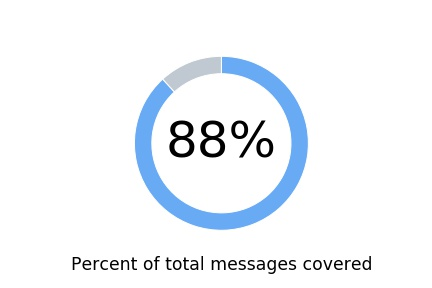
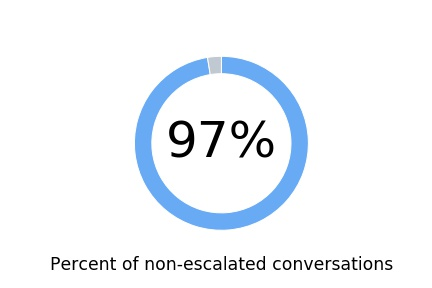

In [15]:
# Display the coverage and effectiveness pie charts
HTML('<tr><th colspan="4"><div align="center"><h2>Coverage and Effectiveness<hr/></h2></div></th></tr>\
<tr>\
    <td style="width:500px">{c_pie}</td>\
    <td style="width:450px"><div align="left"> {c_msg} </div></td>\
    <td style="width:500px">{e_pie}</td>\
    <td style="width:450px"><div align="left"> {e_msg}  </div></td>\
</tr>'
    .format(c_pie=coverage_pie, c_msg = coverage_msg, e_pie = effective_pie, e_msg = effectiveness_msg))

Here, we can see our assistant's coverage and effectiveness. We will have to take a deeper look at both of these metrics to understand the nuances and decide where we should focus next. 

Note that the distinction between a user message and a conversation. A conversation in Watson Assistant represents a session of one or more messages from a user and the associated responses returned to the user from the assistant. A conversation includes a Conversation id for the purposes of grouping a sequence of messages and responses. 

<a id="msg_analysis"></a>
## 5.  Analyze coverage

Here, we take a deeper look at the Coverage of our Watson Assistant.


###  5.1 Display overall coverage<a id="msg_analysis1"></a>


Overall messages
Total Conversations: 4298
Total Messages: 7619




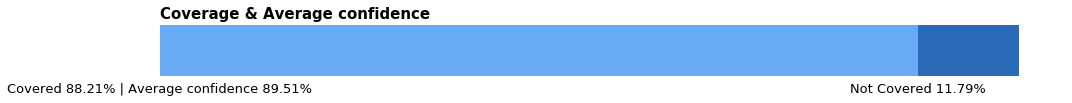

In [16]:
%matplotlib inline  

# Compute the number of conversations in the log
convs = df_coverage['response.context.conversation_id'].nunique()

# Compute the number of messages in the log
msgs = df_coverage['response.context.conversation_id'].size

#Display the results
print('Overall messages\n', "=" * len('Overall messages'), '\nTotal Conversations: ', convs, '\nTotal Messages: ', msgs, '\n\n', sep = '')

#Display the coverage bar chart
display(coverage_barh(coverage, avg_conf, 'Coverage & Average confidence', False))

Here, we see the percentage of messages covered and their average confidence. Now, let us take a look at the coverage over time.


###  5.2 Calculate coverage over time<a id="msg_analysis2"></a>


In [17]:
# Make a copy of df_coverage dataframe
df_Tbot_raw1 = df_coverage.copy(deep=True)

# Group by date and covered and compute the count
covered_counts = df_Tbot_raw1[['Date','Covered']].groupby(['Date','Covered']).agg({'Covered': 'count'})

# Convert numbers to percentage
coverage_grp = covered_counts.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()),2)).rename(columns = {'Covered':'Coverage'}).reset_index()

# Get only covered messages
coverage_time = coverage_grp[coverage_grp['Covered']==True].reset_index(drop = True)

# Determine the number of xticks required
xticks = [d for d in coverage_time['Date']]

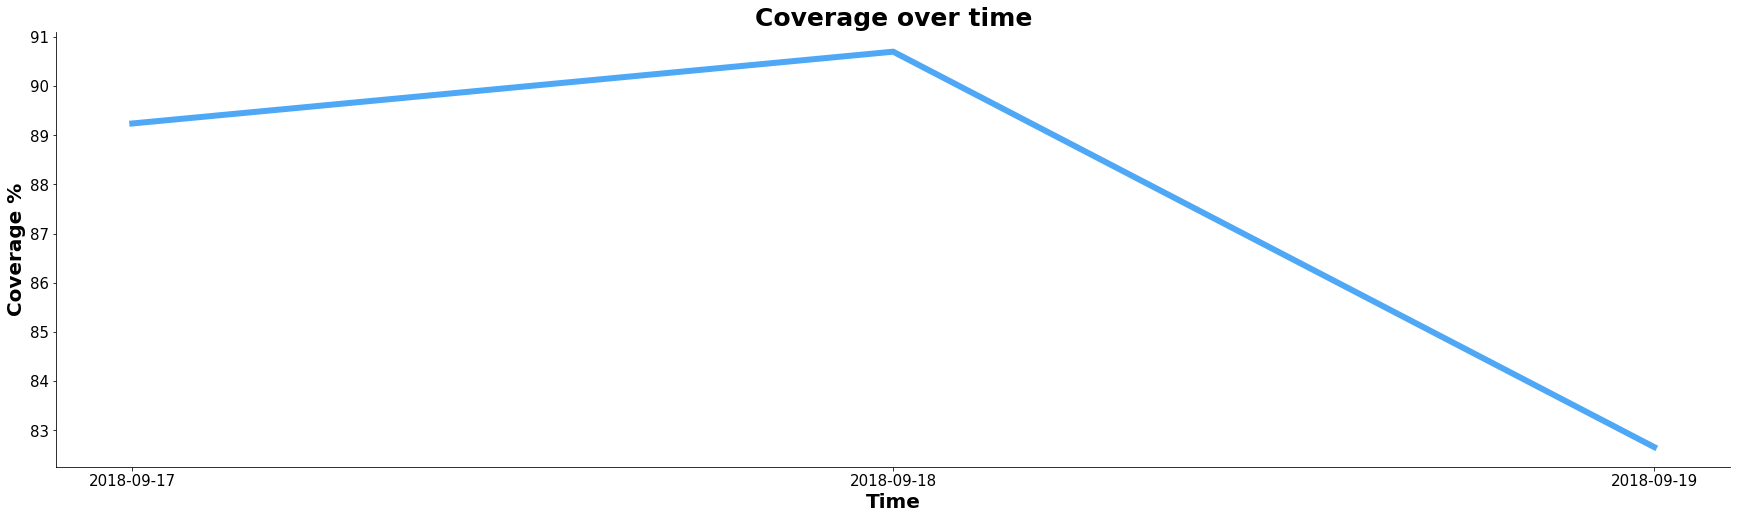

In [18]:
# Plot the coverage over time graph
fig, ax = plt.subplots(figsize=(30,8))

# Format the date on x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis_date()
ax.set_xticks(xticks)

# Plot a line plot if there are more data points
if len(coverage_time) >1:
    ax.plot_date(coverage_time['Date'], coverage_time['Coverage'], fmt = '-', color = '#4fa8f6', linewidth=6)
# Plot a scatter plot if there is only one date on x-axis
else:
    ax.plot_date(coverage_time['Date'], coverage_time['Coverage'], color = '#4fa8f6', linewidth=6)

# Set axis labels and title
ax.set_xlabel("Time", fontsize=20, fontweight='bold')
ax.set_ylabel("Coverage %", fontsize=20, fontweight='bold')
ax.set_title('Coverage over time', fontsize=25, fontweight = 'bold')
ax.tick_params(axis='both', labelsize=15)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

**Note:** Compare the coverage over time with any major updates to your assistant, to see if the changes affected the performance.

<a id="conv_analysis"></a>
## 6. Analyze effectiveness

Here, we will take a deeper look at effectiveness of the assistant

In [19]:
# Get the escalated conversations
df_effective_true = df_effective.loc[df_effective['Escalated_conversation']==True]

# Get the non-escalated conversations
df_not_effective = df_effective.loc[df_effective['Escalated_conversation']==False]

# Calculate percentage of escalated conversations
ef_escalated = float("{0:.2f}".format(100-effective_perc))

# Calculate coverage and non-coverage in escalated conversations
if len(df_effective_true) > 0:
    escalated_covered = float("{0:.2f}".format((df_effective_true['Covered'].value_counts().to_frame()['Covered'][True]/df_effective_true['Covered'].value_counts().sum())*100))
    escalated_not_covered = float("{0:.2f}".format(100- escalated_covered))
else:
    escalated_covered = 0
    escalated_not_covered = 0

# Calculate coverage and non-coverage in non-escalated conversations
if len(df_not_effective) > 0:
    not_escalated_covered = float("{0:.2f}".format((df_not_effective['Covered'].value_counts().to_frame()['Covered'][True]/df_not_effective['Covered'].value_counts().sum())*100))
    not_escalated_not_covered = float("{0:.2f}".format(100 - not_escalated_covered))
else:
    not_escalated_covered = 0
    not_escalated_not_covered = 0

# Calculate average confidence of escalated conversations
if len(df_effective_true) > 0:
    esc_avg_conf = float("{0:.2f}".format(df_effective_true[df_effective_true['Covered']==True]['response.top_intent_confidence'].mean()*100))
else:
    esc_avg_conf = 0
    
# Calculate average confidence of non-escalated conversations
if len(df_not_effective) > 0:
    not_esc_avg_conf = float("{0:.2f}".format(df_not_effective[df_not_effective['Covered']==True]['response.top_intent_confidence'].mean()*100))
else:
    not_esc_avg_conf = 0

###  6.1 Generate excel file and upload to our project<a id="conv_analysis1"></a>

In [20]:
# Copy the effective dataframe
df_excel = df_effective.copy(deep=True)
# Rename columns to generate excel
df_excel = df_excel.rename(columns={'log_id':'Log ID', 'response.context.conversation_id':'Conversation ID',
                           'response.timestamp':'Response Timestamp',
                           'request_input':'Utterance Text',
                           'response_text':'Response Text', 'response.top_intent_intent':'Detected top intent',
                           'response.top_intent_confidence':'Detected top intent confidence',
                           'Intent 2 intent': 'Intent 2', 'Intent 2 confidence':'Intent 2 Confidence', 
                           'Intent 3 intent': 'Intent 3', 'Intent 3 confidence':'Intent 3 Confidence',
                           'response_entities':'Detected Entities', 'Escalated_conversation':'Escalated conversation?',
                           'Covered':'Covered?', 'Not Covered cause':'Not covered - cause',
                           'response.output.nodes_visited_s':'Dialog Flow', 'response_dialog_stack':'Dialog stack',
                           'response_dialog_request_counter':'Dialog request counter', 'response_dialog_turn_counter':'Dialog turn counter'
                           })

existing_columns = ['Log ID', 'Conversation ID', 'Response Timestamp', 'Customer ID (must retain for delete)',
                    'Utterance Text', 'Response Text', 'Detected top intent', 'Detected top intent confidence',
                    'Intent 2', 'Intent 2 Confidence', 'Confidence gap (between 1 and 2)', 'Intent 3', 'Intent 3 Confidence',
                    'Detected Entities', 'Escalated conversation?', 'Covered?', 'Not covered - cause',
                    'Dialog Flow', 'Dialog stack', 'Dialog request counter', 'Dialog turn counter']
# Add new columns for annotating problematic logs
new_columns_excel = ['Response Correct (Y/N)?', 'Response Helpful (Y/N)?', 'Root cause (Problem with Intent, entity, dialog)',
                     'Wrong intent? If yes, put the correct intent. Otherwise leave it blank', 'New intent needed? (A new intent. Otherwise leave blank)',
                     'Add Utterance to Training data (Y/N)', 'Entity missed? If yes, put the missed entity value. Otherwise leave it blank', 'New entity needed? If yes, put the entity name',
                     'New entity value? If yes, put the entity value', 'New dialog logic needed?', 'Wrong dialog node? If yes, put the node name. Otherwise leave it blank','No dialog node triggered']

# Add the new columns to the dataframe
df_excel = df_excel.reindex(columns=[*existing_columns, *new_columns_excel], fill_value='')

In [21]:
# Set maximum sampling size
SAMPLE_SIZE = 200

# Generate all covered sample file
df_covered = df_excel[df_excel['Covered?']==True].reset_index(drop=True)

# Generate all not covered sample file
df_not_covered = df_excel[df_excel['Covered?']==False].reset_index(drop=True)

# Convert to Excel format and upload to COS
generate_excel_measure([df_covered,df_not_covered], ['Covered', 'Not_Covered'], filename='all.xlsx', project_io=project)

# Generate escalated and covered sample file
df_escalated_true = df_excel.loc[df_excel['Escalated conversation?']==True]
df_escalated_covered = df_escalated_true[df_escalated_true['Covered?']==True]
if len(df_escalated_covered) > 0:
    df_escalated_covered = df_escalated_covered.sample(n=min(len(df_escalated_covered), SAMPLE_SIZE), random_state=1).reset_index(drop=True)

# Generate escalated but not covered sample file
df_escalated_not_covered = df_escalated_true[df_escalated_true['Covered?']==False]
if len(df_escalated_not_covered) > 0:
    df_escalated_not_covered = df_escalated_not_covered.sample(n=min(len(df_escalated_not_covered), SAMPLE_SIZE), random_state=1).reset_index(drop=True)

# Covert to Excel format and upload to COS
generate_excel_measure([df_escalated_covered,df_escalated_not_covered], ['Covered', 'Not_Covered'], filename= 'Escalated_sample.xlsx', project_io=project)

# Generate not escalated but covered sample file
df_not_escalated = df_excel.loc[df_excel['Escalated conversation?']==False]
df_not_escalated_covered = df_not_escalated[df_not_escalated['Covered?']==True]
if len(df_not_escalated_covered) > 0:
    df_not_escalated_covered = df_not_escalated_covered.sample(n=min(len(df_not_escalated_covered), SAMPLE_SIZE), random_state=1).reset_index(drop=True)

# Generate not escalated and not covered sample file
df_not_escalated_not_covered = df_not_escalated[df_not_escalated['Covered?']==False]
if len(df_not_escalated_not_covered) > 0:
    df_not_escalated_not_covered = df_not_escalated_covered.sample(n=min(len(df_not_escalated_not_covered), SAMPLE_SIZE), random_state=1).reset_index(drop=True)

# Covert to Excel format and upload to COS
generate_excel_measure([df_not_escalated_covered,df_not_escalated_not_covered], ['Covered', 'Not_Covered'], filename= 'NotEscalated_sample.xlsx', project_io=project)

# Define expiration time (in seconds) of the generated link
expiration_time = 86400 # 24 hours
allSampleLink = generate_link('all.xlsx', project, expiration=expiration_time)
escalatedSampleLink = generate_link('Escalated_sample.xlsx', project, expiration=expiration_time)
notEscalatedSampleLink = generate_link('NotEscalated_sample.xlsx', project, expiration=expiration_time)

###  6.2 Plot breakdown by effectiveness graph<a id="conv_analysis2"></a>


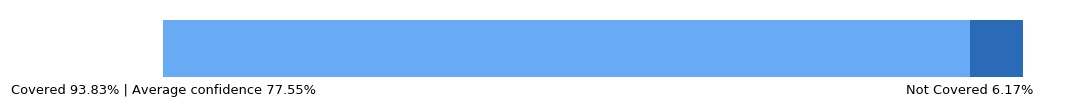
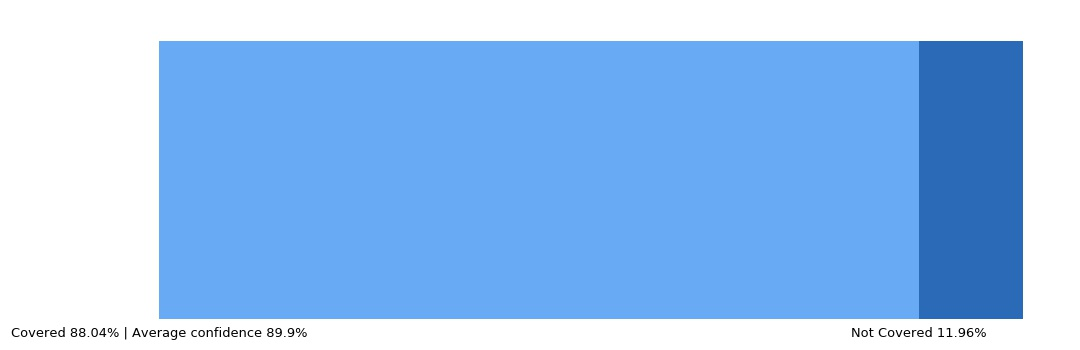

In [22]:
# Get the links to the excels
all_html_link = '<a href={} target="_blank">All.xlsx</a>'.format(allSampleLink)
escalated_html_link = '<a href={} target="_blank">Escalated_sample.xlsx</a>'.format(escalatedSampleLink)
not_escalated_html_link = '<a href={} target="_blank">NotEscalated_sample.xlsx</a>'.format(notEscalatedSampleLink)

# Embed the links in HTML table format
link_html = '<tr><th colspan="4"><div align="left"><a id="file_list"></a>View the lists here: {}&nbsp;&nbsp;&nbsp;{}&nbsp;&nbsp;&nbsp;{}</div></th></tr>'.format(all_html_link, escalated_html_link, not_escalated_html_link)

if 100-effective_perc > 0:
    escalated_bar = coverage_barh(escalated_covered, esc_avg_conf, '', True, 15, width_bar(100-effective_perc))
else:
    escalated_bar = ''

if effective_perc > 0: 
    non_escalated_bar = coverage_barh(not_escalated_covered, not_esc_avg_conf, '' , True , 15,width_bar(effective_perc))
else:
    non_escalated_bar = ''

# Plot the results
HTML('<tr><th colspan="4"><div align="left"><h2>Breakdown by effectiveness<hr/></h2></div></th></tr>\
'+ link_html + '<tr><td style= "border-right: 1px solid black; border-bottom: 1px solid black; width : 400px"><div align="left"><strong>Effectiveness (Escalated)&nbsp;</br>\
<font size="5">{ef_escalated}%</strong></font size></br></div></td>\
    <td style="width:1000px; height=100;">{one}</td></tr>\
<tr><td style= "border-right: 1px solid black; border-bottom: 1px solid black; width : 400px;"><div align="left"><strong>Effectiveness (Not escalated)&nbsp;</br>\
<font size="5">{effective_perc}%</strong></font size></br></div></td>\
    <td style="width:1000px; height=100;border-bottom: 1px solid black;">{two}</td>\
</tr>'.format(ef_escalated= ef_escalated,
              one = escalated_bar, 
              effective_perc = effective_perc, 
              two = non_escalated_bar)) 


You can download all the analyzed data from `All.xlsx`. A sample of escalated and non-escalated conversations are available in `Escalated_sample.xlsx` and `NotEscalated_sample.xlsx` respectively.


<a id="root_cause"></a>
## 7. Root cause analysis of non coverage
Lets us take a look at the reasons for non-coverage of messages

In [23]:
# Count the causes for non-coverage and store results in dataframe
not_covered = pd.DataFrame(df_coverage['Not Covered cause'].value_counts().reset_index())
# Name the columns in the dataframe
not_covered.columns = ['Messages', 'Total']
not_covered

,Messages,Total
0,'anything_else' node,715
1,'#out_of_scope || #off_topic' node,183


<a id="summary"></a>
## 8. Summary and next steps

The metrics described above help you narrow your immediate focus of improvement. We suggest the following two strategies: 

- **Toward improving Effectiveness**

    We suggest focusing on a group of problematic conversations, e.g., escalated conversations, then performing a deeper analysis on these conversation as follows. <br>
    1. Choose to download either the complete conversations ([All.xlsx](#file_list)), or sampled escalated conversations [Escalated_sample.xlsx](#file_list), or non-escalated conversations [NotEscalated_sample.xlsx](#file_list).<br>
    2. Perform a manual assessment of these conversations.<br>
    3. Analyze the results using our __Analyze Watson Assistant Effectiveness__ Jupyter Notebook.


- **Toward improving Coverage**

    For utterances where an intent was found but no response was given. We suggest performing a deeper analysis to identify  root causes, e.g., missing entities or lacking of dialog logic. 

    For utterances where no intent was found, we suggest expanding intent coverage as follows.

    1. Examine utterances from the production log, especially focus on the utterances that are below the confidence (0.2 by default).
    2. If you set a confidence threshold significantly higher than 0.2, we suggest looking at utterances that are below but close to the threshold.
    3. Once you select a collection of utterances, intent expansion, you can focus on intent expansion by two methods:
        - One-by-One: examine each utterance to either change to an existing intent or add a new intent.
        - Unsupervised Learning: perform semantic clustering to generate utterance clusters; examine each cluster to decide (1) adding utterances of an existing intent or (2) creating a new intent.

For more information, please check _Watson Assistant Continuous Improvement Best Practices_.

### <a id="authors"></a>Authors

**Zhe Zhang**, Ph.D. in Computer Science, is an Advisory Software Engineer for IBM Watson AI. Zhe has a research background in Natural Language Processing, Sentiment Analysis, Text Mining, and Machine Learning. His research has been published at leading  conferences and journals including ACL and EMNLP.

**Sherin Varughese** is a Data Scientist at IBM with Watson Assistant team.

### <a id="acknowledgement"></a> Acknowledgement

The authors would like to thank the following members of the IBM Research and Watson Assistant teams for their contributions and reviews of the notebook:  Matt Arnold, Adam Benvie, Kyle Croutwater, Eric Wayne.

Copyright © 2018 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>